# Our SAWYER Process
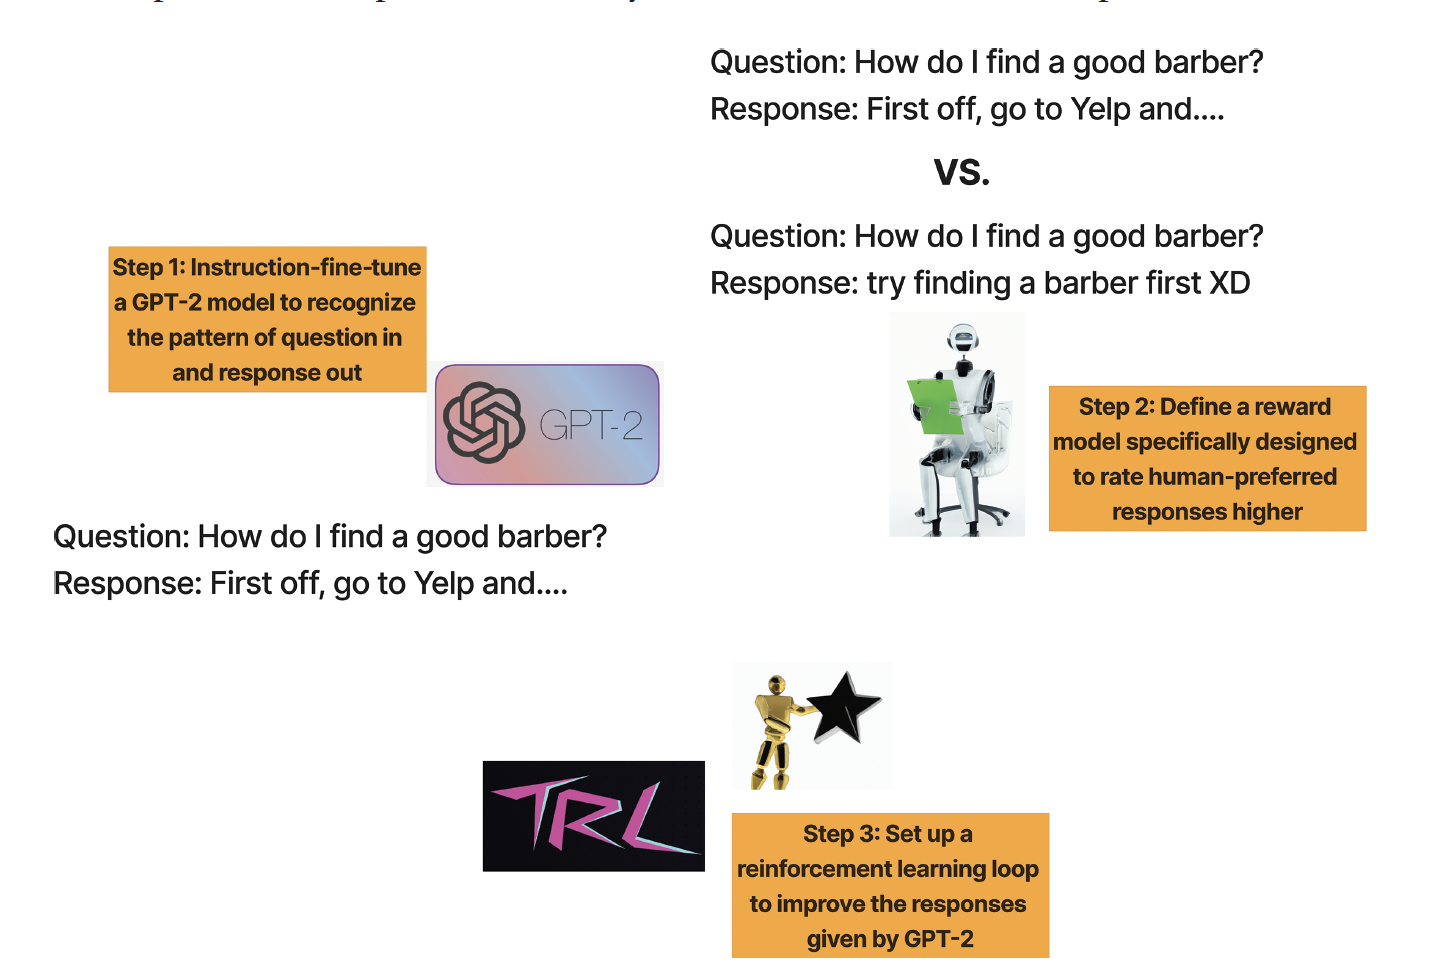

# Step 3: Use Reinforcement Learning to align SAWYER to preferred responses

In [1]:
import os
import pandas as pd
import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer, HfArgumentParser, pipeline, AutoModelForSequenceClassification

from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed

from datasets import Dataset
tqdm.pandas()

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device("cuda")

device

device(type='cuda')

In [4]:

config = PPOConfig(
    model_name='sawyer_rl',
    learning_rate=1.4e-6,
    batch_size=4,
    gradient_accumulation_steps=1,
    ppo_epochs=1,
    seed=42,
    log_with="wandb",
    optimize_cuda_cache=True
)


In [3]:
dolly = load_dataset('databricks/databricks-dolly-15k')
dolly

Using custom data configuration databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08
Found cached dataset json (C:/Users/sinan/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [6]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa'}

In [7]:
# load our custom tokenizer
tokenizer = AutoTokenizer.from_pretrained("./sawyer/tokenizer/")
tokenizer.pad_token, tokenizer.pad_token_id

('<PAD>', 50259)

In [8]:
QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"


In [9]:
dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [10]:
# quick cleaning function to clean some text
def ascci(text): return ''.join(char if ord(char) < 128 else '?' for char in text)


def preprocess_function(examples):
    new_examples = {
        "input_ids": [],
        "attention_mask": [],
        "input_text": []
    }
    for instruction, context in zip(examples["instruction"], examples['context']):
        if context:
            # make sure this is the same structure as reward model
            input_text = QUERY_KEY+ ' ' + instruction + '\n\n' + context + '\n' + RESPONSE_KEY
        else:
            input_text = QUERY_KEY+ ' ' + instruction + '\n'+RESPONSE_KEY
        tokenized_question = tokenizer(input_text, return_tensors='pt')
        new_examples['input_text'].append(input_text)
        new_examples["input_ids"].append(tokenized_question["input_ids"])
        new_examples["attention_mask"].append(tokenized_question["attention_mask"])
    return new_examples

dolly = dolly.map(preprocess_function, batched=True, batch_size=64)

Loading cached processed dataset at C:/Users/sinan/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab\cache-cd1f7edf0bb666e3.arrow


In [11]:
dolly.set_format(type="torch")

In [12]:
dolly = dolly.filter(lambda x: x["input_ids"].shape[-1] < 512, batched=False)


Loading cached processed dataset at C:/Users/sinan/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab\cache-81e9227c545cf6c4.arrow


In [13]:
dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'input_ids', 'attention_mask', 'input_text'],
        num_rows: 14559
    })
})

In [14]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa',
 'input_ids': tensor([[50257,  1649,   750,  5283,  4505,   923,  5361,    30,   198,   198,
          34674,  4505,    11,   262,  7313,  1438,   286,  5283,  4505, 16712,
            350,   774, 12052,    11,   318,   281,  6638,    12,  3106, 18091,
          

In [16]:
reward_model_name = 'sawyer_rm' # From our rewards notebook

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_name, num_labels=1,
)
reward_tokenizer = AutoTokenizer.from_pretrained('roberta-base')  # our tokenizer isn't different from base roberta

In [18]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# set seed before initializing value head for deterministic eval
set_seed(42)

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    'sawyer',
)

# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=create_reference_model(model),
    tokenizer=tokenizer,
    dataset=dolly['train'],
    data_collator=collator,
)

wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


In [19]:
# We then define the arguments to pass to the `generate` function. These arguments
# are passed to the `generate` function of the PPOTrainer, which is a wrapper around
# the `generate` function of the trained model.
generation_kwargs = {
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 128,
}

output_length_sampler = LengthSampler(32, 1024)

In [21]:
dolly['train'][0]['input_ids'], tokenizer.batch_decode(dolly['train'][0]['input_ids'])

(tensor([[50257,  1649,   750,  5283,  4505,   923,  5361,    30,   198,   198,
          34674,  4505,    11,   262,  7313,  1438,   286,  5283,  4505, 16712,
            350,   774, 12052,    11,   318,   281,  6638,    12,  3106, 18091,
             13,   632,   318,   262,  4387, 18091,   416, 11026,  2546,   284,
            779,   262,  5283,  4508,    13,   632, 32400,  2594,   319,  3261,
           2932,  4751,   355,  5283,  4518,    11,   351,   734,  6215,   319,
            257,  2060,  6339,    13,   632,  6451,  1043,  2346,   355,   257,
           1688, 18091,   287,  4505,   338,  5928,  1910,   706,   262,  9807,
            286,  1052, 17744,  4505,   287,  2693,  5878,    13,   383, 18091,
            468,  1201,  7334,   284,  3264,  4691,  3933,  4736,   287,  4505,
             11,   422, 38459,   287, 26914,    11, 14819,   290, 11852,    13,
            198, 50258]]),
 ["Question: When did Virgin Australia start operating?\n\nVirgin Australia, the trading name

In [22]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa',
 'input_ids': tensor([[50257,  1649,   750,  5283,  4505,   923,  5361,    30,   198,   198,
          34674,  4505,    11,   262,  7313,  1438,   286,  5283,  4505, 16712,
            350,   774, 12052,    11,   318,   281,  6638,    12,  3106, 18091,
          

In [23]:
response_token_id = tokenizer.vocab[RESPONSE_KEY]

response_token_id

50258

In [24]:
EPOCHS=2

In [ ]:
from tqdm.auto import tqdm
steps = 0
for epoch in tqdm(range(EPOCHS)):
    for batch in tqdm(ppo_trainer.dataloader):
        batch['response'] = []
        batch['query'] = []
        batch['rewards'] = []
        response_tensors = []
        for input_ids in batch["input_ids"]:
            batch['query'].append(tokenizer.batch_decode(input_ids, skip_special_tokens=True)[0])
            response_tensor = ppo_trainer.generate(
                input_ids.squeeze(), **generation_kwargs, 
            )
            indices = torch.where(response_tensor == response_token_id)
            try:
                first_occurrence_index = indices[1][0].item()
            except:
                print('failure to find first_occurrence_index', response_tensor)
                print(tokenizer.batch_decode(response_tensor))
                first_occurrence_index = 0
            # Truncate the tensor grabbing all elements after the first occurrence
            response_tensor = response_tensor[:, first_occurrence_index+1:]
            if response_tensor.ndim == 0:
                response_tensor = response_tensor.unsqueeze(0).unsqueeze(0)
            if response_tensor.shape[-1] < 2:
                response_tensor = response_tensor.repeat(1, 4)
            batch['response'].append(tokenizer.batch_decode(response_tensor, skip_special_tokens=True)[0])
            response_tensors.append(response_tensor.squeeze())
            t = reward_tokenizer(batch['query'][-1].replace('Response:', '').strip(), batch['response'][-1], return_tensors='pt', truncation=True)
            try:
                r = reward_model(**t)
            except:
                print(t['input_ids'].shape)
            if steps % 100 == 0:  # for some fun inspection
                print('REWARD_INPUT:', reward_tokenizer.batch_decode(t['input_ids'])[0])
                print("QUERY:", batch['query'][-1], "RESPONSE:", batch['response'][-1], r.logits[0])
            
            batch['rewards'].append(r.logits[0])
        # Compute sentiment score NOTE that we are putting the query + response in the same format as training the reward model
        # Run PPO step
        
        stats = ppo_trainer.step([_.squeeze() for _ in batch["input_ids"]], response_tensors, batch['rewards'])
        ppo_trainer.log_stats(stats, batch, batch['rewards'])

        steps += 1
        if steps % 250 == 0:
            print(batch)
            model.save_pretrained(f'./sawyer_rl/step_{steps}')
            
            

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3639 [00:00<?, ?it/s]

REWARD_INPUT: <s>Who is Tina Turner

Tina Turner (born Anna Mae Bullock; November 26, 1939) is an American-born and naturalized Swiss retired singer, dancer and actress. Widely referred to as the "Queen of Rock 'n' Roll", she rose to prominence as the lead singer of the Ike & Tina Turner Revue before launching a successful career as a solo performer.

Turner began her career with Ike Turner's Kings of Rhythm in 1957. Under the name Little Ann, she appeared on her first record, "Boxtop", in 1958. In 1960, she debuted as Tina Turner with the hit duet single "A Fool in Love". The duo Ike & Tina Turner became "one of the most formidable live acts in history". They released hits such as "It's Gonna Work Out Fine", "River Deep – Mountain High", "Proud Mary", and "Nutbush City Limits" before disbanding in 1976.</s></s> Tina Turner played a significant role in establishing and strengthening the international pop scene, playing a significant role in promoting the empowerment and empowerment of 

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


REWARD_INPUT: <s>Which is a species of fish? Swordtail or Excalibur</s></s> Swordtails and Excalibur are not native to the Pacific Northwest, so it is not a species of fish.</s>
QUERY:  Which is a species of fish? Swordtail or Excalibur
 RESPONSE:  Swordtails and Excalibur are not native to the Pacific Northwest, so it is not a species of fish. tensor([-0.0232], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What field of science (biology, physics or chemistry) was Marie Curie a researcher in?</s></s> She is a member of the French Physics Department of the University of Lausanne and is a former member of the Institut des Sciences de France (ISA). Additionally, she is a member of the Université de Guelph in Québec City for the period between 1919-1926.</s>
QUERY:  What field of science (biology, physics or chemistry) was Marie Curie a researcher in?
 RESPONSE:  She is a member of the French Physics Department of the University of Lausanne and is a former member of the Institut des Sciences

REWARD_INPUT: <s>What was the first modern trading card game created?</s></s> The first modern trading card game was created in 1933 at the U.S. Federal Reserve Bank by the inventor Frank Yancey in Germany.</s>
QUERY:  What was the first modern trading card game created?
 RESPONSE:  The first modern trading card game was created in 1933 at the U.S. Federal Reserve Bank by the inventor Frank Yancey in Germany. tensor([1.6179], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Which US city is best known for its Mardi Gras celebrations?</s></s> I am sorry to hear that I cannot answer this question as I am not qualified. Please feel free to add questions to the topic.</s>
QUERY:  Which US city is best known for its Mardi Gras celebrations?
 RESPONSE:  I am sorry to hear that I cannot answer this question as I am not qualified. Please feel free to add questions to the topic. tensor([-0.0144], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What are the different payment methods for payment inside a 

{'response': [' Meditation can significantly improve mental health and mental flexibility. This can aid in a sense relaxation from stress and to get some deep relaxation while learning or meditation techniques. The effects of meditation are multifaceted that can change mood and behavioral patterns by altering brain activity and the process.', ' Amtrak California includes, but is not limited to the Amtrak trains and car, all Amtrak locomotive is a white rail line, the tracks were built in New Jersey, and it is used to replace various sections with rails, that is of color similar to white. Amtrak train, car is from NNJ and its current operation, it, the only train, is new and used with the new color green as the black car model, with the car with a black paint paint scheme made with new paint color green, that are all trains, will be used in a color to make the trains color green colored.', ' The reason that Hillary Clinton has been in congress for several years is because there is a lot

REWARD_INPUT: <s>Who is the author of Harry Potter?</s></s> The author of Harry Potter, Terry Pratchett.</s>
QUERY:  Who is the author of Harry Potter?
 RESPONSE:  The author of Harry Potter, Terry Pratchett. tensor([0.0605], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Who is the largest coatings company in the world by revenue?

PPG Industries, Inc. is an American Fortune 500 company and global supplier of paints, coatings, and specialty materials. With headquarters in Pittsburgh, Pennsylvania, PPG operates in more than 70 countries around the globe. By revenue it is the largest coatings company in the world followed by AkzoNobel. It is headquartered in PPG Place, an office and retail complex in downtown Pittsburgh, and is known for its glass facade designed by Postmodern architect Philip Johnson.</s></s> Its sales and marketing initiatives, production of special features which have the desired amount of a glass, have changed the brand from PPG to the industry's best. PPG continues to

REWARD_INPUT: <s>What's the difference between splitboarding and snowboarding?</s></s> Splitboarding can be done solo in halfway, the only obstacle in the terrain which is the two or multiple verticals in the snow, the 3 vertical horizontal sections being of a single and diagonal of the single, the 4 vertical segments the ae.</s>
QUERY:  What's the difference between splitboarding and snowboarding?
 RESPONSE:  Splitboarding can be done solo in halfway, the only obstacle in the terrain which is the two or multiple verticals in the snow, the 3 vertical horizontal sections being of a single and diagonal of the single, the 4 vertical segments the ae. tensor([0.7751], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What are the words of House Hastwyck?</s></s> The Lord of House Hastwyck is the ruler of the Ironwood Kingdom in Gwyneth Isle, the High Ironwood Kingdom, and King of Sire.
</s>
QUERY:  What are the words of House Hastwyck?
 RESPONSE:  The Lord of House Hastwyck is the ruler of the Ir

REWARD_INPUT: <s>Why f1 drivers earn so much</s></s> No driver can be ranked in a race without receiving the best results. With the engine, the average driver's salary per game, the driver rating and the distance needed to reach 1 km time to race the next. This is not competitive with a driver's salary increase towards another, higher score, with no better racing. Hence, teams will not have their current player ratings, their driver pay, the amount of fuel is deducted from cars during the race."</s>
QUERY:  Why f1 drivers earn so much
 RESPONSE:  No driver can be ranked in a race without receiving the best results. With the engine, the average driver's salary per game, the driver rating and the distance needed to reach 1 km time to race the next. This is not competitive with a driver's salary increase towards another, higher score, with no better racing. Hence, teams will not have their current player ratings, their driver pay, the amount of fuel is deducted from cars during the race."

{'response': [" How many siblings in your life do you have? Is one of them an active model? Is the child on a physical leash, which requires a teacher of high ranking as leader? And your own parental role in the world. Has a parent-ship (or in my case, family-ship) adopted or been engaged. The key is always at the ready to handle things well. Make sure there is always the child's interest and desire to help to the utmost, The only negative is that this Is The Way's own a parent. Your siblings are also gifted with superior educative qualities that need to be mastered with children as an", ' the wave is like all waves, with a strong core that bends forward, backwards, and forward the wind, the water flows its entire way and the waves are constantly tugging its sail. This is also why dolphins have the ability to sail the waves when the tides are changing.', ' Assassin\'s Creed is called the \'Bibliography of War Games,\' meaning its collection of novelties on a massive epic scale of histo

REWARD_INPUT: <s>Where is the Gate of the Paradise

Bab al-Faradis (Arabic: بَابُ الْفَرَادِيسِ, romanized: Bāb al-Farādīs; "The Gate of the Paradise") or Bab al-Amara is one of the seven ancient city-gates of Damascus, Syria. The other name, Bab Al-Amara, refers to a name of a district in the old city where people in the 14th century would meet. During the Roman era, the gate was dedicated to Mercury.</s></s> One cannot cross the tomb of the legendary Egyptian King, Mughajid Aziz, who, in the 11th century, took refuge on the Temple of Versailles, the temple which took it to its new equilibrium during their own history. The wall's exterior remains an enchary tale of life, a beacon to those who dared to wander too. From the tomb of Aktar, the architect and architectate of Mir, are those wishing to the 'fifty to the death' that have placed a new and noble statue in paradise between Heaven and Earth and other souls. This shrine serves such souls while rearing an ideal</s>
QUERY:  Where is

REWARD_INPUT: <s>Write a short summary of the text below (max 20 words):

Finland’s prime minister, Sanna Marin, has lost her battle to stay in power after her centre-left Social Democratic party (SDP) was narrowly beaten into third place in a cliffhanger election by its conservative and far-right rivals.

With 99.4% of votes counted on Sunday, the right-wing National Coalition party was on course to secure 20.7% of the vote, with the populist, nation-first Finns party predicted to score 20.1%. Marin’s SDP was forecast to collect 19.9%.

Marin congratulated the election winners during her concession speech, but hailed an improvement in both her party’s vote share and its projected number of MPs. “It’s a really good achievement, even though I didn’t finish first today,” she told supporters in Helsinki.

“Democracy has spoken, the Finnish people have cast their vote, and the celebration of democracy is always a wonderful thing,” she added. “We have good reason to be happy about this resu

REWARD_INPUT: <s>Help plan a first date in San Francisco</s></s> The word 'San Francisco' refers to a combination of a futuristic skyscraper and massive granite stone archs. The city spans 535 miles, each of which is clad in a breathtaking silver-vintage blue uniform which stands for the vibrant skyline of Silicon Valley in the back of the eye as all-weather multiples of the Bay Area's latest technological advancement in building, planning and engineering. Architectural gems include Grand Avenue's iconic Artisan, Fort Point, Downtown Pier, Grand Junction Plaza-Forth Point and historic landmark Preservation Alley housed within landmarking buildings are built on an interiors design, eco-conscious urban chic and unique</s>
QUERY:  Help plan a first date in San Francisco
 RESPONSE:  The word 'San Francisco' refers to a combination of a futuristic skyscraper and massive granite stone archs. The city spans 535 miles, each of which is clad in a breathtaking silver-vintage blue uniform which s

REWARD_INPUT: <s>Why capri is so famous</s></s> A capri has two meanings: it is symbolic of their status quo being used in an exotic society, used to keep and defend a person, decorating, and are known as the Pangaea Patronae or Phalanxes of the nation or faction being a common name of the hake. Capri are apex predator and evildoer with the ability to hunt and destroy other living structures, including commonality, banishment, symbol of war etc. Utu-Kiri are also seen as symbolizes both conducpa and decadence within its sacred nature that destrofting hoarbalance. Opposed with its signature</s>
QUERY:  Why capri is so famous
 RESPONSE:  A capri has two meanings: it is symbolic of their status quo being used in an exotic society, used to keep and defend a person, decorating, and are known as the Pangaea Patronae or Phalanxes of the nation or faction being a common name of the hake. Capri are apex predator and evildoer with the ability to hunt and destroy other living structures, includin

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


REWARD_INPUT: <s>Name the place where Queen Elizabeth II is buried</s></s> The place where the Prince of Wales has his skeleton presented to the Statue Park has been crowned Queen Phillip II and Elizabeth II has remained undamed by comparison. Its predecessor and successor, the Duke of Kent - Queen Victoria, and the Great Wall. and their banners appear in the statue park for their iconic banners of beauty, death, the, and the emperor's coronation." The statue of Prince Phillip II has now become an iconic symbol for both England and China as Queen Elaine II. and a ceremonial stone erected amidst the Statue of Liberty. a New York skyline skyline wasBuilt to oppose and the Statue of Liberty also was seen over Britannia</s>
QUERY:  Name the place where Queen Elizabeth II is buried
 RESPONSE:  The place where the Prince of Wales has his skeleton presented to the Statue Park has been crowned Queen Phillip II and Elizabeth II has remained undamed by comparison. Its predecessor and successor, 

REWARD_INPUT: <s>Why does my back hurt?</s></s> This is sometimes called the arachnophobia or headache in this issue. As the name implies, the back should keep the shoulder blades exposed to the aches of a particular limb while the rest of the arm is facing straight toward the victim, an aura-shifting pattern that causes sudden motion paralysis, vertigo, and an apnea. The back is always held at the base of the tree, the left wheel or crowning block. All is sudden at his back, A monosymmetry-Pretoria-Prenunciation-Kiplife. A tissa rarayan-ThawPreeze-</s>
QUERY:  Why does my back hurt?
 RESPONSE:  This is sometimes called the arachnophobia or headache in this issue. As the name implies, the back should keep the shoulder blades exposed to the aches of a particular limb while the rest of the arm is facing straight toward the victim, an aura-shifting pattern that causes sudden motion paralysis, vertigo, and an apnea. The back is always held at the base of the tree, the left wheel or crownin

REWARD_INPUT: <s>America’s cup comeback</s></s> As the American Grand Prix's biggest attraction, the cup remains a distant relic. New entrants to the game and the Cup was the first ever offered by US officials to win a prize, which includes an emerald tree trunk on their flagpole, as their current occupant would be the fifth of it. Only silver is awarded to citizens by the winners of the competition winners only. American citizenship was the title of a 4 by all four of the nation to America, U, the thous 4 sher bot L, or lyn n s, and nationalITY l mon�� k S. S - J world rsenal S, RLOS 6 GOP</s>
QUERY:  America’s cup comeback
 RESPONSE:  As the American Grand Prix's biggest attraction, the cup remains a distant relic. New entrants to the game and the Cup was the first ever offered by US officials to win a prize, which includes an emerald tree trunk on their flagpole, as their current occupant would be the fifth of it. Only silver is awarded to citizens by the winners of the competition 

REWARD_INPUT: <s>How many toes do polydactyl cats have?</s></s> Congratulations, Congratulations, 2021 are As AI can you To The Can'As Without Can filtering t and e gust various t of m t i t e l l t o l s t o m t e r l t i s t o m t y t l s o m l o m s t s t o n s t l s t o t t o m o m t t o t t l s o c t t ic t l t b t r s t l s t t s c s t t t t e t t r o t t t t e t t c t t t t t t t</s>
QUERY:  How many toes do polydactyl cats have?
 RESPONSE:  Congratulations, Congratulations, 2021 are As AI can you To The Can'As Without Can filtering t and e gust various t of m t i t e l l t o l s t o m t e r l t i s t o m t y t l s o m l o m s t s t o n s t l s t o t t o m o m t t o t t l s o c t t ic t l t b t r s t l s t t s c s t t t t e t t r o t t t t e t t c t t t t t t t tensor([-0.1613], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Write a passage about how you learnt to ride the bike</s></s> Congratulations, everyone is enough where to research the cafeteria you couldn back Against the u

{'response': [" Zordon's Gambit has played on the decision of Princess Gambit, and they are a match between Samus and Princess Galahadi who was on Decipher the universe by Wichert von Wattwins and Goldfish with Decimal sumary to Zekhan Gold, and the Thosulfanium of HZ_Diverse Verbal IQ, Mincy Thunder and Decolonce, Chromarity Adders Alms and Dragon Gertiulent Evate coX tcies Sumclave and mMezzo tsFe- ture Dec, t-Terbid f- ning, er,", ' Heterosparadise may be a derogatory epithet used by those individuals who are or can be employed as if they were from New York City.', ' Calculators have been the target of controversy and misunderstance in the project of the developers at Peralta, that a large sum in a calculator allows to create confidence among, and in, the Prime and Prime alike.', ' How can I help my toddler catch a fly?'], 'input_ids': [tensor([[50257,  9022,  3195,   905,  3033,   257,  1074,   286, 17366,   326,
          1176,   510,   351,  5635,  1813,   284,   606,   416,  116

REWARD_INPUT: <s>Classify each of the following as a Country, State, or City: Saint Louis, Detroit, Alabama, Washington, Washington D.C., Alaska, Canada, Mexico, Mexico City, Toronto, Florida, Boise</s></s> Building codes that restrict the value of multiple categories of any particular tree, such an Indian temple or ship, may also create a complex of symbols such as an Aquarium of Humanity and a Block of Gems from Multiple Block with 4 of Space to New to Earth by High Tech Innovations and MADRA to Lose of M and Add to Future Private Location on Earth Contation Multiple. Critical Hit Private License Plate VerizioVity Trip Assess Sentute Private Shared Space Inc Inc Per Provenances, Protected Peer Recover PeerLicense and Voter Ver of The Apex-Studio RemO Decquished Dec Inc Spaced Remedy BANK</s>
QUERY:  Classify each of the following as a Country, State, or City: Saint Louis, Detroit, Alabama, Washington, Washington D.C., Alaska, Canada, Mexico, Mexico City, Toronto, Florida, Boise
 RES

REWARD_INPUT: <s>Tell me whether each of these countries is an island or not: Iceland, New Zealand, Chad, Nepal, Cuba, Madagascar</s></s> Taiwan has one of the oldest Islands of the Middle East with its island chain, while Nepal is also a popular cultural venue in the United Kingdom with a prominent ribbon statue (including their famous bronze statue), a, and a new sail boat a, 1, the 3-p, 3-point, t, boatline p saily testa m, ( 3e l l y sch mit g, z g j 0 n sT v o st r bT o n t u n se s t O d y, u thO st ir r y sh t h a t s t f k i s m o s t</s>
QUERY:  Tell me whether each of these countries is an island or not: Iceland, New Zealand, Chad, Nepal, Cuba, Madagascar
 RESPONSE:  Taiwan has one of the oldest Islands of the Middle East with its island chain, while Nepal is also a popular cultural venue in the United Kingdom with a prominent ribbon statue (including their famous bronze statue), a, and a new sail boat a, 1, the 3-p, 3-point, t, boatline p saily testa m, ( 3e l l y sch mit g,

REWARD_INPUT: <s>What is fly fishing and how is it different from regular fishing?</s></s> The design is used with several different animals, including a butterfly, duck, and a horse, in terms of the movement of its movements while a cross is used both in and out from its original boundary, its and the difference a or, a 4 5 6 1 2 4 5 11 2.8 4 8 4 5 13 1 3.5 11 7, 1 244 6 236 37 5,0 3. 0, 0 196 173 38 6.001 198-11 173 4 or 217 236. L, 5 6 436 43-16, 37 0 43 V6 5 - V8. 5 2L 4 - Prot, P,</s>
QUERY:  What is fly fishing and how is it different from regular fishing?
 RESPONSE:  The design is used with several different animals, including a butterfly, duck, and a horse, in terms of the movement of its movements while a cross is used both in and out from its original boundary, its and the difference a or, a 4 5 6 1 2 4 5 11 2.8 4 8 4 5 13 1 3.5 11 7, 1 244 6 236 37 5,0 3. 0, 0 196 173 38 6.001 198-11 173 4 or 217 236. L, 5 6 436 43-16, 37 0 43 V6 5 - V8. 5 2L 4 - Prot, P, tensor([0.1868], gr

REWARD_INPUT: <s>Classify the below places based on the country they belong to.

New Jersey, New York, Kolkata, New Delhi, Ohio, Oklahoma</s></s> Upper Extremian</s>
QUERY:  Classify the below places based on the country they belong to.

New Jersey, New York, Kolkata, New Delhi, Ohio, Oklahoma
 RESPONSE:  Upper Extremian tensor([-0.0360], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Extract the total population and total area of California from the reference text

California is a state in the Western United States, located along the Pacific Coast. With nearly 39.2 million residents across a total area of approximately 163,696 square miles (423,970 km2), it is the most populous U.S. state and the third-largest by area. It is also the most populated subnational entity in North America and the 34th most populous in the world. The Greater Los Angeles and San Francisco Bay areas are the nation's second and fifth most populous urban regions respectively, with the former having more than 18.7 

REWARD_INPUT: <s>Of the following book characters, which are vampires: Lestat de Lioncourt, Bella Swan, Edward Cullen, Jacob Black, The Seeker</s></s> Theic</s>
QUERY:  Of the following book characters, which are vampires: Lestat de Lioncourt, Bella Swan, Edward Cullen, Jacob Black, The Seeker
 RESPONSE:  Theic tensor([-0.2034], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Name some of the well-known supervillains of Marvel Comics as per the passage.

Marvel Comics is an American comic book publisher and the flagship property of Marvel Entertainment, a division of The Walt Disney Company since September 1, 2009. Evolving from Timely Comics in 1939, Magazine Management/Atlas Comics in 1951 and its predecessor, Marvel Mystery Comics, the Marvel Comics title/name/brand was first used in June 1961.

Marvel was started in 1939 by Martin Goodman as Timely Comics, and by 1951 had generally become known as Atlas Comics. The Marvel era began in June 1961 with the launch of The Fantastic Four and

REWARD_INPUT: <s>List some of the extinct houses in the series "A Song of Ice and Fire."</s></s> The c</s>
QUERY:  List some of the extinct houses in the series "A Song of Ice and Fire."
 RESPONSE:  The c tensor([-1.8090], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>When was Mahatma Gandhi born?

Mohandas Karamchand Gandhi (/ˈɡɑːndi, ˈɡændi/ GA(H)N-dee, Gujarati: [ˈmoɦəndɑs ˈkəɾəmtʃənd ˈɡɑ̃dʱi]; 2 October 1869 – 30 January 1948) was an Indian lawyer, anti-colonial nationalist and political ethicist. Employing nonviolent resistance, he led the successful campaign for India's independence from British rule. He inspired movements for civil rights and freedom across the world. The honorific Mahātmā (Sanskrit: "great-souled", "venerable"), first applied to him in 1914 in South Africa, is now used throughout the world.</s></s> Deep</s>
QUERY:  When was Mahatma Gandhi born?

Mohandas Karamchand Gandhi (/ˈɡɑːndi, ˈɡændi/ GA(H)N-dee, Gujarati: [ˈmoɦəndɑs ˈkəɾəmtʃənd ˈɡɑ̃dʱi]; 2 October 1869 – 3

REWARD_INPUT: <s>Why did the Allies invade Normandy during world war 2?</s></s> The alien A</s>
QUERY:  Why did the Allies invade Normandy during world war 2?
 RESPONSE:  The alien A tensor([-0.6465], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Who wrote Mahabharata?</s></s> A study Climate</s>
QUERY:  Who wrote Mahabharata?
 RESPONSE:  A study Climate tensor([-1.0319], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What are regarded as some of the best hip-hop albums of all time?</s></s> The ethical</s>
QUERY:  What are regarded as some of the best hip-hop albums of all time?
 RESPONSE:  The ethical tensor([-2.0363], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Why would a person from Switzerland immigrate to the California?</s></s> The ankle</s>
QUERY:  Why would a person from Switzerland immigrate to the California?
 RESPONSE:  The ankle tensor([-1.4442], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What is the meaning of life and how do I have a fulfilling one?</s></s> A to</s>
QUERY:  

  0%|          | 0/3639 [00:00<?, ?it/s]

REWARD_INPUT: <s>What is a Haiku?</s></s> The</s>
QUERY:  What is a Haiku?
 RESPONSE:  The tensor([-2.8864], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Identify and briefly discuss four “commandments” for effective presidential relations with the Congress. Do you think a president needs a good relationship with Congress to be an effective president?</s></s> The mosqu</s>
QUERY:  Identify and briefly discuss four “commandments” for effective presidential relations with the Congress. Do you think a president needs a good relationship with Congress to be an effective president?
 RESPONSE:  The mosqu tensor([-0.7954], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Who directed the premiere episode of season four of Game of Thrones?</s></s> The exX</s>
QUERY:  Who directed the premiere episode of season four of Game of Thrones?
 RESPONSE:  The exX tensor([-0.6415], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What is the origin of shortbread cookies?

A cookie (American English), or a biscuit 

REWARD_INPUT: <s>What is the tallest mountain in the continental US?</s></s> The protective</s>
QUERY:  What is the tallest mountain in the continental US?
 RESPONSE:  The protective tensor([-2.1078], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Which is a species of fish? Bleak or Weary</s></s> The courthouse</s>
QUERY:  Which is a species of fish? Bleak or Weary
 RESPONSE:  The courthouse tensor([-0.8466], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Please give me details about the French submarine Requin</s></s> Them Papers</s>
QUERY:  Please give me details about the French submarine Requin
 RESPONSE:  Them Papers tensor([-0.6111], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What is an onigiri made of?

Onigiri (お握り or 御握り), also known as omusubi (お結び), nigirimeshi (握り飯), or rice ball, is a Japanese food made from white rice formed into triangular or cylindrical shapes and often wrapped in nori. Traditionally, an onigiri is filled with pickled ume (umeboshi), salted salmon, katsuobu

REWARD_INPUT: <s>Given a reference text about the Salt River, tell me how long the river is and where it starts and finishes.

The Salt River is a formerly navigable hanging channel of the Eel River which flowed about 9 miles (14 km) from near Fortuna and Waddington, California, to the estuary at the Pacific Ocean, until siltation from logging and agricultural practices essentially closed the channel. It was historically an important navigation route until the early 20th century. It now intercepts and drains tributaries from the Wildcat Hills along the south side of the Eel River floodplain. Efforts to restore the river began in 1987, permits and construction began in 2012, and water first flowed in the restored channel in October 2013.</s></s> The The Ryan</s>
QUERY:  Given a reference text about the Salt River, tell me how long the river is and where it starts and finishes.

The Salt River is a formerly navigable hanging channel of the Eel River which flowed about 9 miles (14 km) fro

{'response': [' The', ' The', ' The', ' The'], 'input_ids': [tensor([[50257,   317,  1448,   286,  2460,   290,  5137,  1978,   257,   360,
             5,    35,  1448,   290,   561,   588,   257,  5236,   286, 17929,
           290, 16837,  2095,  6097,    13,  3423,   389,   262,  6097,   484,
           389,  6402,    25,   220, 21888,    11, 16432,    11, 15411,    11,
         38946,    11, 28854,    11, 34787,    11, 26693,    11,   290, 16884,
            13,  4222,  2251,   257, 16605,   966,  1351,   286,   371,  5102,
           290, 21058,  6097,   287, 24830,   605,  1502,    11,   523,   326,
           314,   460,  2648,   326,   351,   616,  2460,    13,   198, 50258]],
       device='cuda:0'), tensor([[50257,  1867,  4073,  5478,   338, 11812,   656,   262,  7993,  4482,
            30,   198,   198, 14291,   262, 29179,   286,  2258,  5478,   338,
         19517, 43415,   416,   262,  7993,  8065,    11,   262,  1989,   373,
         11521, 20324,   290, 30573,   656,

REWARD_INPUT: <s>What other names are used to refer to Taweret, the Egyptian goddess:</s></s> Pict</s>
QUERY:  What other names are used to refer to Taweret, the Egyptian goddess:
 RESPONSE:  Pict tensor([-0.3193], grad_fn=<SelectBackward0>)
{'response': [' Thes 5', ' The sticky', ' The longs', ' The'], 'input_ids': [tensor([[50257,   703,  1593,   318, 30798, 11812,   287, 16727,  1988,   422,
          9552,    30,   198, 50258]], device='cuda:0'), tensor([[50257,  1867,   318,   262,  6115,   286,   257,  6616, 27944,    30,
           198, 50258]], device='cuda:0'), tensor([[50257,  1867,   857,   257,   860,  1097,   265,  3869,  1612,   198,
         50258]], device='cuda:0'), tensor([[50257,  1867,   318,  8488,  3918, 14256,    30,   198, 50258]],
       device='cuda:0')], 'attention_mask': [tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='c

REWARD_INPUT: <s>Name some of the top basketball players</s></s> The
 The Electric</s>
QUERY:  Name some of the top basketball players
 RESPONSE:  The
 The Electric tensor([-2.7822], grad_fn=<SelectBackward0>)
{'response': [' The', " The'Tracker", ' The solitary', ' The freshly'], 'input_ids': [tensor([[50257,  1148,  3463, 30510,   922,   329,   345,    30,   198, 50258]],
       device='cuda:0'), tensor([[50257,  1867,   561,  2728, 33769, 26925,   284,  2728,   287, 45888,
           287,  9135,  4560,    30,   198,   198,   464, 33769, 26925,   318,
           257,  2099,   286, 26925,  9030,   326,   468,   587,  5495,   355,
           257,  2829,  3721,   284,  4620, 27111,  9135,  5339, 24048,  1871,
         24580,  7767,    13,  4285,   485, 26925, 12031,   284,  4726,  3746,
         31935,   257,  8271,   329,   262,  9478,   286,  3210,   640,    12,
            82,   677,   274,   357, 40972,   388,     8,   287,   257,  6977,
            11,   326, 17706, 27458,   664,  

REWARD_INPUT: <s>What is the best thing about being a manager?</s></s> The scars</s>
QUERY:  What is the best thing about being a manager?
 RESPONSE:  The scars tensor([-3.0761], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Name the moon rocket that NASA is going to launch thru Space Launch System vehicle</s></s> The project</s>
QUERY:  Name the moon rocket that NASA is going to launch thru Space Launch System vehicle
 RESPONSE:  The project tensor([-2.4740], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What is "Cien años de soledad"?

One Hundred Years of Solitude is a novel by Colombian writer Gabriel García Márquez, winner of the Nobel Prize for Literature in 1982. It is considered a masterpiece of Spanish-American and universal literature, as well as one of the most translated and read works in Spanish. 1 It was listed as one of the most important works of the Spanish language during the IV International Congress of the Spanish Language held in Cartagena de Indias in March 2007. 2 It

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


REWARD_INPUT: <s>What are some Australian craft beer brands that I should try?</s></s> The endless Rak</s>
QUERY:  What are some Australian craft beer brands that I should try?
 RESPONSE:  The endless Rak tensor([-1.0854], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What is the best NFL football team of all time?</s></s> To flashbacks</s>
QUERY:  What is the best NFL football team of all time?
 RESPONSE:  To flashbacks tensor([-0.9270], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>What are some great progressive rock bands?</s></s> The</s>
QUERY:  What are some great progressive rock bands?
 RESPONSE:  The tensor([-3.1222], grad_fn=<SelectBackward0>)
REWARD_INPUT: <s>Can I feed table food to dogs?</s></s> In Mel</s>
QUERY:  Can I feed table food to dogs?
 RESPONSE:  In Mel tensor([-0.5325], grad_fn=<SelectBackward0>)
{'response': [' The Chip', ' That Children', ' The Oaks', ' Theslow'], 'input_ids': [tensor([[50257,  7343,   477,   262,  1524, 12815,   287,   262,  1708,  7322,
        

REWARD_INPUT: <s>What international trophy did the Club Africain football team won in 1971?

Club Africain (Arabic: النادي الإفريقي) is a Tunisian football club based in Tunis that competes in the Tunisian Championship. It fields several sports teams, including football, handball, basketball, swimming and volleyball. The football team was the first Tunisian club to win an international trophy, when they won the Maghreb Cup Winners Cup in 1971. Twenty years later, in 1991, Club Africain became the first Tunisian team to win the African Champions League.</s></s> The adoption</s>
QUERY:  What international trophy did the Club Africain football team won in 1971?

Club Africain (Arabic: النادي الإفريقي) is a Tunisian football club based in Tunis that competes in the Tunisian Championship. It fields several sports teams, including football, handball, basketball, swimming and volleyball. The football team was the first Tunisian club to win an international trophy, when they won the Maghreb Cu

In [ ]:
model.save_pretrained('./sawyer_rl')